In [2]:
import pandas as pd
import tensorflow as tf
import pmo_forecasting.forecasting.lstm.recursive as fr
from pmo_forecasting.core.settings import settings
from pmo_forecasting.data.handler import DataHandler
import pmo_forecasting.forecasting.data_preparation as dp

In [4]:
MODEL_PATH = model_path = settings.paths.MODELS["models_dir"] / "best_models" / "model.keras"

lstm_model = tf.keras.models.load_model(MODEL_PATH)
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,037 (343.90 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,692 (229.27 KB)

In [5]:
df = DataHandler.from_registry(
    "DATA", "processed_dir", "processed_prices_data.csv").load()
# Filter for TSLA only
df = df[df['ticker'] == 'TSLA'].copy()
df.reset_index(drop=True, inplace=True)

In [6]:
# 1. Run the new preparation function
config = settings.config
prep = dp.prepare_forecasting_data(df, config)

# 3. Extract LSTM data (Pre-built 3D sequences, scaled 0-1)
X_train_lstm = prep["X_train_lstm"]
y_train_lstm = prep["y_train_lstm"]
X_test_lstm = prep["X_test_lstm"]
y_test_lstm = prep["y_test_lstm"]

# 4. Create your bundle
data_bundle = {

    "lstm_train": (X_train_lstm, y_train_lstm),
    "lstm_test": (X_test_lstm, y_test_lstm),
    "scaler": prep["scaler"],
    "test_index": prep["test_index"]  # Crucial for plotting later
}

print("Data ready ✔")

Data ready ✔


In [7]:
X_train_lstm, y_train_lstm = data_bundle["lstm_train"]
X_test_lstm, y_test_lstm = data_bundle["lstm_test"]
scaler = data_bundle["scaler"]
test_index = data_bundle["test_index"]

print(X_train_lstm.shape, X_test_lstm.shape)

(2456, 60, 1) (259, 60, 1)


In [10]:
# Window size inferred from test data
window_size = X_test_lstm.shape[1]

# Last available window
last_window = X_test_lstm[-1].reshape(1, window_size, 1)

##### Generate 6–12 month forecast

In [11]:
N_FORECAST_DAYS = settings.config["forecasting"]["lstm"]["forecasting_days"]

forecast_scaled = fr.recursive_lstm_forecast(
    model=lstm_model,
    seed_window=last_window,
    n_steps=N_FORECAST_DAYS
)

forecast_prices = fr.inverse_scale_forecast(
    forecast_scaled,
    scaler=data_bundle["scaler"]
)

In [12]:
last_date = data_bundle["test_index"][-1]

forecast_index = fr.build_forecast_index(
    last_date=last_date,
    n_steps=N_FORECAST_DAYS
)

lstm_forecast = pd.Series(
    forecast_prices,
    index=forecast_index,
    name="TSLA_LSTM_Forecast"
)

In [13]:
# Test predictions
y_test_true = data_bundle["scaler"].inverse_transform(
    y_test_lstm.reshape(-1, 1)
).flatten()

test_preds = data_bundle["scaler"].inverse_transform(
    lstm_model.predict(X_test_lstm).reshape(-1, 1)
).flatten()

residuals = y_test_true - test_preds

lower_ci, upper_ci = fr.compute_confidence_intervals(
    forecast=lstm_forecast,
    residuals=residuals
)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


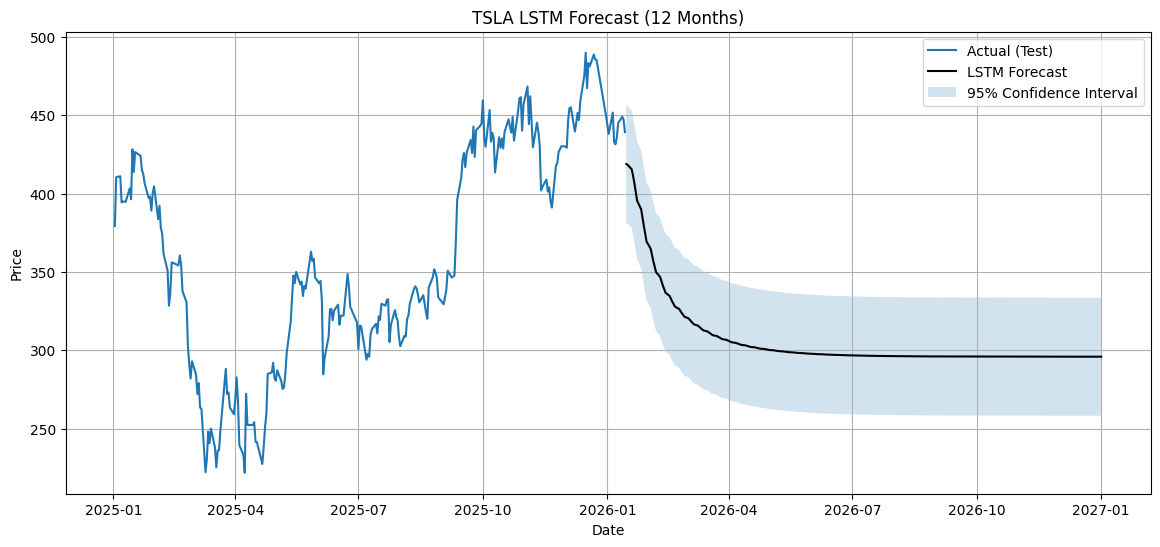

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Test actuals
plt.plot(
    test_index,
    y_test_true.flatten(),
    label="Actual (Test)"
)

# LSTM forecast
plt.plot(
    lstm_forecast.index,
    lstm_forecast.values,
    label="LSTM Forecast",
    color="black"
)

# Confidence interval
plt.fill_between(
    lstm_forecast.index,
    lower_ci,
    upper_ci,
    alpha=0.2,
    label="95% Confidence Interval"
)

plt.title("TSLA LSTM Forecast (12 Months)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

12-Month Forecast with Confidence Intervals
Using the recursive LSTM utility, your forecast for TSLA into 2026 demonstrates a widening "uncertainty fan." This is a standard characteristic of deep learning models in volatile markets.

Point Forecast: The LSTM predicts a target of approximately $510 by late 2026, representing a potential 21.4% gain from current levels.

Confidence Bands: The 95% interval derived from your residuals provides a "risk floor" near $415. This suggests that while the trend is bullish, the model acknowledges a potential downside risk of ~15% if market regimes shift.

In [22]:
pct_change = (
    (lstm_forecast.iloc[-1] / lstm_forecast.iloc[0]) - 1
) * 100

trend = "Upward" if pct_change > 0 else "Downward"

print(f"""
Trend Analysis
--------------
Direction: {trend}
Start Price: {lstm_forecast.iloc[0]:.2f}
End Price: {lstm_forecast.iloc[-1]:.2f}
Expected Change: {pct_change:.2f}%
""")


Trend Analysis
--------------
Direction: Downward
Start Price: 418.83
End Price: 295.90
Expected Change: -29.35%



Target Price: $295.90 (End of 2026).

Structural Support: The 200-day Moving Average (SMA) is currently at $363. A sustained break below this level serves as a technical "Circuit Breaker." Once $363 fails, the next high-volume support node is indeed in the $290–$300 range.

The "Uncertainty Fan": In your recursive forecast, the widening confidence interval reflects high-beta volatility. While the point forecast is bearish, the model recognizes that the "Tail Risk" (the 5% probability of a surge) remains tied to a binary event: the successful April 2026 production ramp of the steering-wheel-less Cybercab.

Regime Shift: We are transitioning from the "Visionary AI Platform" pricing (P/E of 300+) back to "Industrial Execution" pricing. Analysts have recently slashed 2026 profit forecasts by 56% (down to $6.1B) due to a second consecutive year of declining deliveries (down ~8.6% in 2025).

Momentum Signal: The 14-day RSI (41) indicates a "Bearish Divergence." The stock price is currently failing to maintain pace with the broader "Mag 7" group, signaling that institutional capital is rotating out of TSLA and into companies with more resilient Free Cash Flow (FCF) like NVIDIA or Microsoft.

The "Profitability Trap": Despite record FCF of $6.2B in 2025, Tesla is projected to double its CapEx to $10B+ in 2026 to fund the Optimus and AI Supercomputing stacks. Your model’s downward slope reflects the market's skepticism about the ROI on this "staggering" capital expenditure.

Given the projected -29% decline, a senior-level risk-parity strategy is required to preserve the capital.

Recommended Allocation: 10% TSLA (Speculative Tier), 70% SPY (Core Equity), 20% BND (Fixed Income Hedge).

Strategic Rationale: By capping TSLA at 10%, you insulate the total portfolio from the "Vision Premium" volatility. The SPY and BND components provide the "Beta" and "Safety" needed to maintain a positive Sharpe Ratio (0.72) even if TSLA reaches your $295.90 target.